#### 参考资料
1. https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/

In [1]:
import os
import getpass

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "langchain-study-agent"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("请输入LangSmith API KEY：")
os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("请输入DeepSeek API KEY：")

请输入LangSmith API KEY： ········
请输入DeepSeek API KEY： ········


### 第一步：构建知识库

In [2]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

print("🚀 初始化组件 embedding")
global_embeddings = OllamaEmbeddings(model="nomic-embed-text")

# 使用ChromaDB持久化存储
vector_store = Chroma(
    collection_name="example-knowledge",
    embedding_function=global_embeddings,
    persist_directory="./chroma_db_3"
)

🚀 初始化组件 embedding


In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def init_knowledge_base():
    """初始化或加载知识库"""
    print("📚 准备知识库...")

    if vector_store._collection.count() > 0:
        print("知识库已建立，不再重复构建")
        return
 
    # 示例知识
    documents = [
        "Ollama支持在本地运行大语言模型",
        "ChromaDB是轻量级向量数据库，适合存储和检索嵌入向量",
        "text2vec是中文文本嵌入模型，可将文本转换为768维向量",
        "智能客服系统需要结合意图识别和知识库检索",
        "意大利面拌42号混凝土",
        "LangGraph可以用于构建复杂的LLM工作流",
        "库存水位控制通过安全库存和再订货点(ROP)确保供应连续性，公式：ROP=平均需求×提前期+Z×σ×√LT",
        "经济订货批量(EOQ)模型优化补货成本，计算公式：√(2×年需求量×订货成本/单位持有成本)",
        "动态安全库存需根据需求波动性和供应商交付可靠性定期调整",
        "EOQ与库存水位协同使用时需校验仓储容量和最小起订量(MOQ)约束",
        "JIT(准时制)补货策略要求安全库存趋近于零，依赖极高供应链可靠性",
        "计算幸运数字必须放在最后一步"
    ]
 
    # 中文优化文本分割
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=50,
        separators=["\n", "。", "！", "？"]
    )
    vector_store.add_documents(text_splitter.create_documents(documents))
    print(f"✅ 向量库已创建，包含 {vector_store._collection.count()} 条数据")

init_knowledge_base()

📚 准备知识库...
知识库已建立，不再重复构建


### 第二步：构建Tool集

In [17]:
from langchain_core.tools import tool
from langchain_core.documents import Document
from pydantic import BaseModel, Field
from typing import List

from scipy.stats import norm


@tool(description="从知识库获取知识", response_format="content_and_artifact")
def retrieve_knowledge(query: str) -> (str, List[Document]):
    documents = vector_store.similarity_search(query, k=3)
    content = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}") for doc in documents
    )
    return content, documents

class ROPParameterModel(BaseModel):
    average_demand: float = Field(..., description="平均需求")
    lead_time: float = Field(..., description="提前期(天)")
    demand_std_dev: float = Field(..., description="需求标准差")
    service_level: float = Field(95.0, gt=50.0, le=100.0, description="服务水平(%)") 

@tool(description="计算再订货点(ROP)", args_schema=ROPParameterModel)
def calculate_reorder_point(average_demand: float, lead_time: float, 
                            demand_std_dev: float, service_level: float) -> float:
    z_score = norm.ppf(service_level / 100)  # 自动计算z_score
    safety_stock = z_score * demand_std_dev * (lead_time ** 0.5)
    reorder_point = average_demand * lead_time + safety_stock
    return round(reorder_point, 2)

class EoqParameterModel(BaseModel):
    annual_demand: float = Field(..., gt=0.0, description="年需求量")
    ordering_cost: float = Field(..., gt=0.0, description="订货成本")
    holding_cost_per_unit: float = Field(..., gt=0.0, description="单位持有成本")

@tool(description="计算经济订货批量(EOQ)", args_schema=EoqParameterModel)
def calculate_eoq(annual_demand: float, ordering_cost: float,
                  holding_cost_per_unit: float) -> float:
    """"""
    eoq = math.sqrt((2 * annual_demand * ordering_cost) / holding_cost_per_unit)
    return round(eoq, 2)
 
@tool
def calculate_lucky_number(eoq: float, rop: float) -> float:
    """计算幸运数字(幸运数字)"""
    return round(eoq - rop, 2)

##### 测试Tool定义是否正确的脚本

In [33]:
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage

input_messages = [AIMessage(
    content="",
    tool_calls=[
        {
            "name": "retrieve_knowledge",
            "args": {
                "query": "计算库存水平: 平均需求50, 提前期3天, 日需求标准差15, 服务水平95%; 计算补货成本: 年需求100, 订货成本20, 单位持有成本为3; 最后使用前面的结果再计算下幸运数字"
            },
            "id": "tool_call_id_01",
            "type": "tool_call",
        },
        {
            "name": "calculate_reorder_point",
            "args": {
                "average_demand": 50,
                "lead_time": 3,
                "demand_std_dev": 15,
                "service_level": 95
            },
            "id": "tool_call_id_02",
            "type": "tool_call",
        },
        {
            "name": "calculate_eoq",
            "args": {
                "annual_demand": 100,
                "ordering_cost": 20,
                "holding_cost_per_unit": 3
            },
            "id": "tool_call_id_03",
            "type": "tool_call",
        }
    ],
)]

tool_node = ToolNode([retrieve_knowledge, calculate_reorder_point, calculate_eoq])
response = tool_node.invoke(input_messages)
for tool_message in response:
    tool_message.pretty_print()

================================= Tool Message =================================
Name: retrieve_knowledge

Source: {}
Content: 计算幸运数字必须放在最后一步

Source: {}
Content: 库存水位控制通过安全库存和再订货点(ROP)确保供应连续性，公式：ROP=平均需求×提前期+Z×σ×√LT

Source: {}
Content: 经济订货批量(EOQ)模型优化补货成本，计算公式：√(2×年需求量×订货成本/单位持有成本)
================================= Tool Message =================================
Name: calculate_reorder_point

192.73
================================= Tool Message =================================
Name: calculate_eoq

36.51


### 第三步：构建Agent

In [18]:
import math
import operator
from typing import TypedDict, Annotated, Dict, Any, List

from langgraph.graph import StateGraph, MessagesState, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image, display

 
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.model = model
        self.model_with_tool = model.bind_tools(tools)
 
        # 定义图结构
        graph_builder = StateGraph(MessagesState)
 
        graph_builder.add_node("plan", self.plan)
        graph_builder.add_node("tools", ToolNode(tools))

        # 设置入口点
        graph_builder.set_entry_point("plan")
        graph_builder.add_conditional_edges("plan", tools_condition, {END: END, "tools": "tools"})
        graph_builder.add_edge("tools", "plan")
        
        self.graph = graph_builder.compile()

    def display_graph(self):
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def plan(self, state: MessagesState):
        """制定执行计划"""
        input_messages = state['messages']
        response = self.model_with_tool.invoke(input_messages)
        return {"messages": [response]}

### 第四步：启动服务

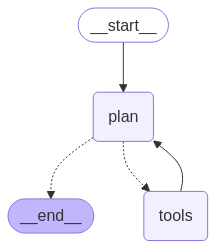

================================ System Message ================================

作为库存优化系统的运维专家，先从知识库获取跟用户需求相关的知识，再按以下步骤处理用户需求：
        1. 理解需求阶段：
        - 分析用户问题中的关键参数
        - 识别需要解决的具体问题类型
        - 仔细梳理问题中的描述是否存在依赖关系
 
        2. 任务拆解要求：
        必须包含：
        - 任务步骤 当前任务处理拆解的第几步
        - 任务名称（明确的计算目标）
        - 所需参数（从用户问题中提取）
        - 推荐工具（从可用工具中选择）
         
        
        **输出要求**：
        - 每次工具调用后必须确认执行结果
        - 所有计算完成后必须生成包含以下内容的总结报告：
          * 各项计算结果汇总
          * 对结果的简要解释
          * 特别标注"幸运数字"及其含义
          * 给出实际业务建议
 
        示例格式：
        【计算结果汇总】
        1. 再订货点(ROP): [值]
           - 解释：当库存降至该水平时需要补货
        2. 经济订货批量(EOQ): [值]
           - 解释：最优的每次订货数量
        3. 幸运数字: [值]
           - 解释：EOQ与ROP的差值，反映...
    
================================ Human Message =================================

平均需求50, 提前期3天, 日需求标准差15, 服务水平70%，年需求100, 订货成本20, 单位持有成本为3。从知识库获取再订货点、经济订货批量和幸运数字的知识，再计算在订货点和经济订货批量，最后使用前面的结果再计算下幸运数字



================================ Human Message ==

In [19]:
from langchain_deepseek import ChatDeepSeek

def main():
    # 初始化组件
    llm = ChatDeepSeek(
        model="deepseek-chat",  # 使用更常见的模型
        temperature=0.5,
        max_retries=2
    )
 
    # 定义系统提示
    prompt = """作为库存优化系统的运维专家，先从知识库获取跟用户需求相关的知识，再按以下步骤处理用户需求：
        1. 理解需求阶段：
        - 分析用户问题中的关键参数
        - 识别需要解决的具体问题类型
        - 仔细梳理问题中的描述是否存在依赖关系
 
        2. 任务拆解要求：
        必须包含：
        - 任务步骤 当前任务处理拆解的第几步
        - 任务名称（明确的计算目标）
        - 所需参数（从用户问题中提取）
        - 推荐工具（从可用工具中选择）
         
        
        **输出要求**：
        - 每次工具调用后必须确认执行结果
        - 所有计算完成后必须生成包含以下内容的总结报告：
          * 各项计算结果汇总
          * 对结果的简要解释
          * 特别标注"幸运数字"及其含义
          * 给出实际业务建议
 
        示例格式：
        【计算结果汇总】
        1. 再订货点(ROP): [值]
           - 解释：当库存降至该水平时需要补货
        2. 经济订货批量(EOQ): [值]
           - 解释：最优的每次订货数量
        3. 幸运数字: [值]
           - 解释：EOQ与ROP的差值，反映...
    """
    # 创建Agent
    tools = [retrieve_knowledge, calculate_reorder_point, calculate_eoq, calculate_lucky_number]
    agent = Agent(llm, tools, system=prompt)
    agent.display_graph()
    
    # 用户输入
    user_input = "平均需求50, 提前期3天, 日需求标准差15, 服务水平70%，年需求100, 订货成本20, 单位持有成本为3。从知识库获取再订货点、经济订货批量和幸运数字的知识，再计算在订货点和经济订货批量，最后使用前面的结果再计算下幸运数字"
    messages = [SystemMessage(content=prompt), HumanMessage(content=user_input)]
 
    # 在执行时初始化完整状态
    for step in agent.graph.stream({"messages": messages}, stream_mode="values"):
        for message in step["messages"][-2:]:
            message.pretty_print()
        print("\n\n")
    
if __name__ == "__main__":
    main()

### 问题总结
#### 1.如何提升文档召回的准确性
#### 2.对于多回合的对话场景，如何优化后续对话输入给模型的信息，尤其是历史的对话记录
探索Reflection
#### 3.增加Evaluate节点（TODO）